In [1]:
import cv2
import numpy as np
import subprocess
import time
import datetime
import pytz
import matplotlib.colors as mcolors
from astral import LocationInfo
from astral.sun import sun
from scipy.interpolate import splprep, splev
from collections import deque
import multiprocessing
import matplotlib.pyplot as plt
import math

## Colors

In [2]:
def find_midpoint(start_time, end_time):
    return start_time + (end_time - start_time) / 2

def get_color(progress, start_color, end_color, exponent=1):
    c1 = np.array(mcolors.hex2color(start_color))
    c2 = np.array(mcolors.hex2color(end_color))
    color = (1 - progress**exponent) * c1 + progress**exponent * c2
    return tuple(int(255 * x) for x in color)

def get_colors():
    london_tz = pytz.timezone('Europe/London')
    london_datetime = datetime.datetime.now(london_tz)
    london_old_datetime = datetime.datetime.now(london_tz) - datetime.timedelta(days=1)
    london_next_datetime = datetime.datetime.now(london_tz) + datetime.timedelta(days=1)

    london_date = london_datetime.date()
    london_old_date = london_old_datetime.date()
    london_next_date = london_next_datetime.date()

    city = LocationInfo(latitude=51.537052, longitude=-0.183325)
    s = sun(city.observer, date=london_date)
    y = sun(city.observer, date=london_old_date)
    n = sun(city.observer, date=london_next_date)

    old_dusk = y['dusk'].astimezone(london_tz)
    current_dawn = s['dawn'].astimezone(london_tz)
    old_midnight = find_midpoint(old_dusk, current_dawn)

    current_dusk = s['dusk'].astimezone(london_tz)
    current_sunrise = s['sunrise'].astimezone(london_tz)
    current_sunset = s['sunset'].astimezone(london_tz)
    current_noon = find_midpoint(current_sunrise, current_sunset)
    next_dawn = n['dawn'].astimezone(london_tz)
    current_midnight = find_midpoint(current_dusk, next_dawn)

    color_lookup = {
        'midnight': {
            'line': {
                'start': '#ced4da',
                'end': '#f8f9fa'
            },
            'background': {
                'start': '#6c757d',
                'end': '#212529',
            },
            'exponent': 0.25
        },
        'dawn': {
            'line': {
                'start': '#f8f9fa',
                'end': '#ced4da'
            },
            'background': {
                'start': '#212529',
                'end': '#6c757d'
            },
            'exponent': 4
        },
        'sunrise': {
            'line': {
                'start': '#ced4da',
                'end': '#6c757d'
            },
            'background': {
                'start': '#6c757d',
                'end': '#ced4da'
            },
            'exponent': 4
        },
        'afternoon': {
            'line': {
                'start': '#6c757d',
                'end': '#212529'
            },
            'background': {
                'start': '#ced4da',
                'end': '#f8f9fa'
            },
            'exponent': .25
        },
        'sunset': {
            'line': {
                'start': '#212529',
                'end': '#6c757d'
            },
            'background': {
                'start': '#f8f9fa',
                'end': '#ced4da'
            },
            'exponent': 4
        },
        'dusk': {
            'line': {
                'start': '#6c757d',
                'end': '#ced4da'
            },
            'background': {
                'start': '#ced4da',
                'end': '#6c757d'
            },
            'exponent': .25
        }
    }

    if london_datetime <= old_midnight:
        approaching = 'midnight' 
        progress = (london_datetime - old_dusk).seconds / (old_midnight - old_dusk).seconds
    elif london_datetime <= current_dawn:
        approaching = 'dawn'
        progress = (london_datetime - old_midnight).seconds / (current_dawn - old_midnight).seconds
    elif london_datetime <= current_sunrise:
        approaching = 'sunrise'
        progress = (london_datetime - current_dawn).seconds / (current_sunrise - current_dawn).seconds
    elif london_datetime <= current_noon:
        approaching = 'afternoon'
        progress = (london_datetime - current_sunrise).seconds / (current_noon - current_sunrise).seconds
    elif london_datetime <= current_sunset:
        approaching = 'sunset'
        progress = (london_datetime - current_noon).seconds / (current_sunset - current_noon).seconds
    elif london_datetime <= current_dusk:
        approaching = 'dusk'
        progress = (london_datetime - current_sunset).seconds / (current_dusk - current_sunset).seconds
    elif london_datetime <= current_midnight:
        approaching = 'midnight' 
        progress = (london_datetime - current_dusk).seconds / (current_midnight - current_dusk).seconds
    else:
        return None
    line_color = get_color(progress=progress, start_color=color_lookup[approaching]['line']['start'], end_color=color_lookup[approaching]['line']['end'], exponent=color_lookup[approaching]['exponent'])
    background_color = get_color(progress=progress, start_color=color_lookup[approaching]['background']['start'], end_color=color_lookup[approaching]['background']['end'], exponent=color_lookup[approaching]['exponent'])
    return background_color, line_color


## Stream Input

In [3]:
def format_headers(headers):
    header_str = ""
    for key, value in headers.items():
        header_str += f"{key}: {value}\r\n"
    return header_str

def initialize_ffmpeg_process(headers, width, height):
    # Create FFmpeg command with custom headers
    ffmpeg_command = [
        'ffmpeg',
        '-headers', headers,
        '-i', 'https://videos-3.earthcam.com/fecnetwork/AbbeyRoadHD1.flv/chunklist_w.m3u8',
        '-f', 'rawvideo',
        '-pix_fmt', 'gray',
        '-s', f'{width}x{height}',
        '-r', '30',
        '-'
    ]
    process = subprocess.Popen(ffmpeg_command, stdout=subprocess.PIPE, bufsize=10**9)
    return process

height = 720
width = 1080
fps = 30
headers = {
    'Accept': '*/*',
    'Accept-Language': 'en-US,en;q=0.9',
    'Connection': 'keep-alive',
    'Origin': 'https://www.abbeyroad.com',
    'Referer': 'https://www.abbeyroad.com/',
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'cross-site',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
    'sec-ch-ua': '"Google Chrome";v="119", "Chromium";v="119", "Not?A_Brand";v="24"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"macOS"'
}
formatted_headers = format_headers(headers)

ffmpeg_process = initialize_ffmpeg_process(formatted_headers, width, height)

# Now you can continue with other tasks while ffmpeg is running
print("FFmpeg process started with PID:", ffmpeg_process.pid)

FFmpeg process started with PID: 92731


ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --

In [11]:
%%time
frame = ffmpeg_process.stdout.read(height * width)

CPU times: user 435 μs, sys: 665 μs, total: 1.1 ms
Wall time: 691 μs


In [12]:
%%time
array = np.frombuffer(frame, dtype=np.uint8).reshape((height, width))

CPU times: user 20 μs, sys: 659 μs, total: 679 μs
Wall time: 680 μs


In [393]:
%%time
gamma = 0.5  # Gamma value less than 1
inv_gamma = 1.0 / gamma

# Build a lookup table mapping pixel values [0, 255] to their adjusted gamma values
lookup_table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)], dtype=np.uint8)

# Apply the gamma correction using the lookup table
emphasized_darker = cv2.LUT(array, lookup_table)

CPU times: user 2.35 ms, sys: 1.69 ms, total: 4.03 ms
Wall time: 2.69 ms


In [513]:
%%time
current_time = time.time()
sin_value = (np.sin(current_time) + 1) / 2  # Normalize sin_value to be between 0 and 1

# Calculate dynamic kernel size based on sin_value
kernel_size_dilate = int(3 + 6 * sin_value)  # Vary kernel size between 3 and 9
kernel_size_erode = int(4 + 8 * sin_value)  # Vary kernel size between 4 and 12

# Create dynamic kernels
kernel_dilate = np.random.randint(0, 2, (kernel_size_dilate, kernel_size_dilate)).astype(np.uint8)
kernel_erode = np.random.randint(0, 2, (kernel_size_erode, kernel_size_erode)).astype(np.uint8)

# Apply dilation with the time-based random kernel
dilated = cv2.dilate(emphasized_darker, kernel_dilate, iterations=1)

# Apply erosion with another time-based random kernel
eroded = cv2.erode(dilated, kernel_erode, iterations=1)

CPU times: user 2 ms, sys: 1.1 ms, total: 3.09 ms
Wall time: 1.82 ms


In [14]:
%%time
edges = cv2.Canny(array, threshold1=125, threshold2=150, apertureSize=3)

CPU times: user 4.02 ms, sys: 4.61 ms, total: 8.63 ms
Wall time: 2.92 ms


CPU times: user 3.06 ms, sys: 1.06 ms, total: 4.12 ms
Wall time: 775 μs


In [372]:
%%time
transformed = 12 + 12 * np.sin(np.pi * higher_contrast / 255)

CPU times: user 13.3 ms, sys: 3.59 ms, total: 16.9 ms
Wall time: 14.4 ms


In [458]:
%%time
kernel = np.ones((2, 3), np.uint8)  # You can adjust the kernel size for different effects
dilated = cv2.dilate(higher_contrast, kernel, iterations=1)

CPU times: user 2.16 ms, sys: 1.88 ms, total: 4.04 ms
Wall time: 2.36 ms


In [501]:
%%time
kernel = np.ones((2, 3), np.uint8)
eroded = cv2.erode(higher_contrast, kernel, iterations=1)

CPU times: user 3.08 ms, sys: 3.07 ms, total: 6.16 ms
Wall time: 3.58 ms


CPU times: user 11.9 ms, sys: 2.16 ms, total: 14.1 ms
Wall time: 13 ms


In [344]:
%%time
darker_values = (25 / np.log(256)) * np.log1p(array)

CPU times: user 14.1 ms, sys: 1.63 ms, total: 15.8 ms
Wall time: 14.3 ms


In [6]:
%%time
blurred_image = cv2.pyrMeanShiftFiltering(array, sp=15, sr=30)


error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/segmentation.cpp:368: error: (-210:Unsupported format or combination of formats) Only 8-bit, 3-channel images are supported in function 'pyrMeanShiftFiltering'


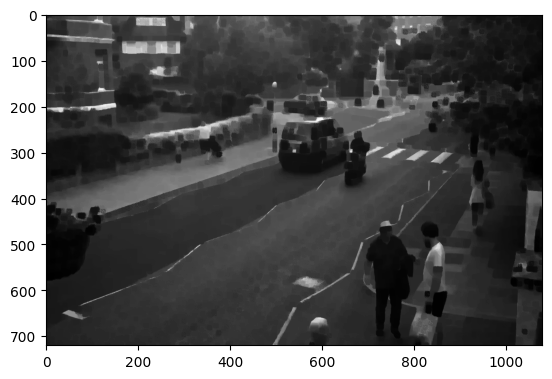

In [ ]:
plt.imshow(eroded, cmap='gray')

In [10]:
%%timeit
matrix_3d = np.full((height, width, 3), background_color, dtype=np.uint8)

2.83 ms ± 31.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit
matrix_3d = np.zeros((height, width, 3), dtype=np.uint8)
matrix_3d[:] = background_color

3.59 ms ± 21.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 μs


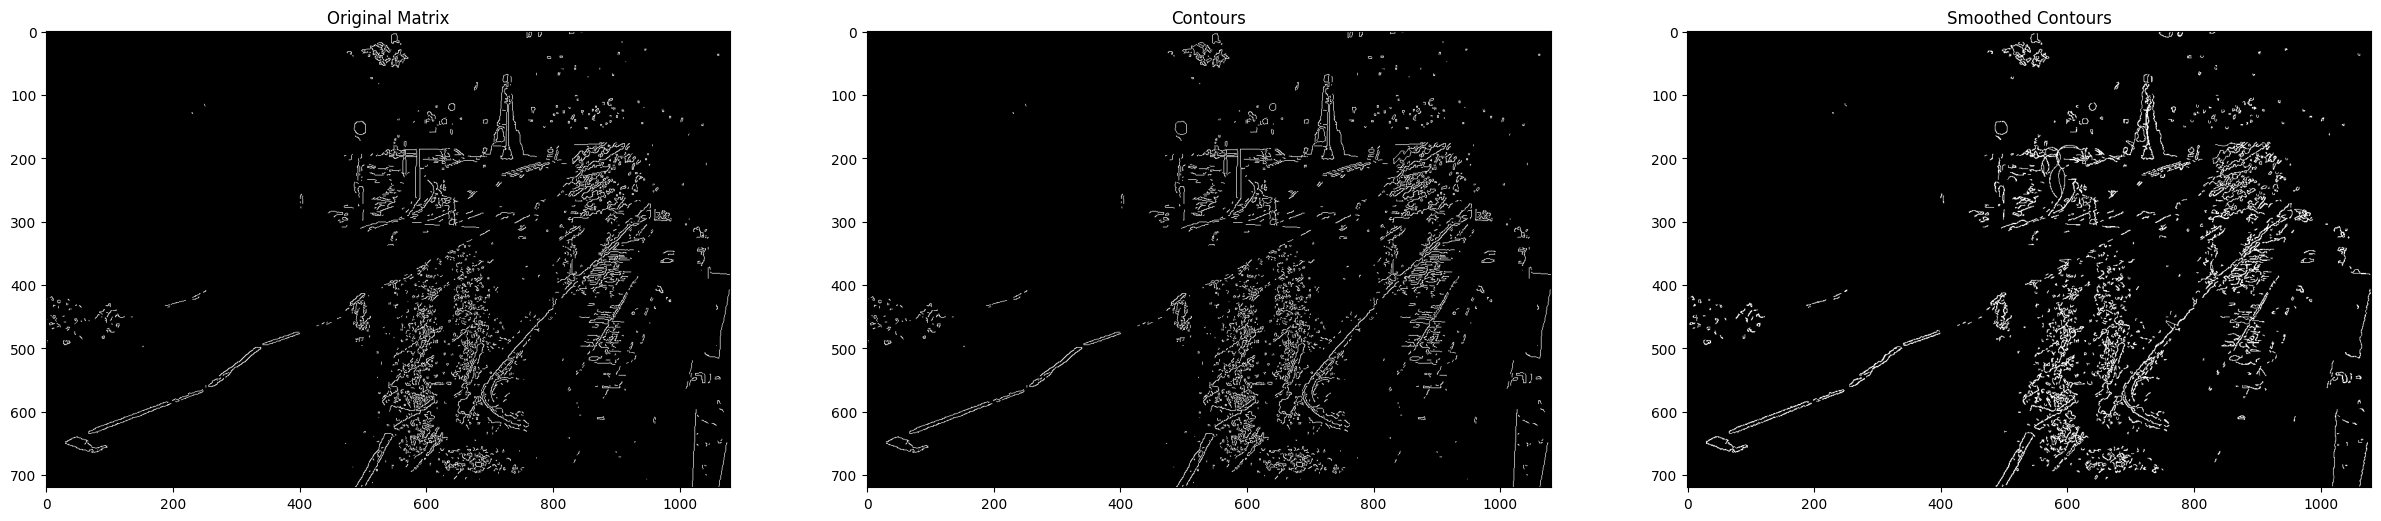

In [25]:
%time


# Convert matrix to binary image (0 and 1)
binary_matrix = (edges == 255).astype(np.uint8)

# Find contours
contours, _ = cv2.findContours(binary_matrix, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an empty image to draw the contours
contour_img = np.zeros_like(edges)

# Draw the original contours
for contour in contours:
    contour_img = cv2.drawContours(contour_img, [contour], -1, (255), 1)

# Smooth the contours using splines
smoothed_contour_img = np.zeros_like(edges)

for contour in contours:
    if contour.shape[0] > 3:  # Need at least 4 points to fit a spline
        # Convert to a list of points
        contour = contour.squeeze()
        x = contour[:, 0]
        y = contour[:, 1]

        # Fit a spline to the contour
        tck, u = splprep([x, y], s=10, k=3)
        u_new = np.linspace(u.min(), u.max(), 1000)
        x_new, y_new = splev(u_new, tck, der=0)

        # Draw the smoothed contour
        smoothed_points = np.array([x_new, y_new], dtype=np.int32).T
        smoothed_contour_img = cv2.polylines(smoothed_contour_img, [smoothed_points], isClosed=False, color=(255), thickness=1)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(edges, cmap='gray')
ax[0].set_title('Original Matrix')

ax[1].imshow(contour_img, cmap='gray')
ax[1].set_title('Contours')

ax[2].imshow(smoothed_contour_img, cmap='gray')
ax[2].set_title('Smoothed Contours')

plt.show()
